In [1]:
# https://www.kaggle.com/vbookshelf/simple-cell-segmentation-with-keras-and-u-net

In [5]:
import pandas as pd
import numpy as np
import os
import sys
import random

import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set some parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
NUM_TEST_IMAGES = 30

In [7]:
# get a list of files in each folder
img_list = os.listdir('Roads DataSet/road_segmentation_ideal/training/input')
mask_list = os.listdir('Roads DataSet/road_segmentation_ideal/training/output')

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)

df_images.head()


image_id has_mask
0   img-1000Cropped.png      yes
1  img-1000Cropped2.png      yes
2   img-1001Cropped.png       no
3  img-1001Cropped2.png       no
4   img-1002Cropped.png      yes

In [8]:
df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

(1531, 3)

In [9]:
df_masks.head(10)

image_id has_mask               mask_id
0    img-1000Cropped.png      yes   img-1000Cropped.png
1   img-1000Cropped2.png      yes  img-1000Cropped2.png
4    img-1002Cropped.png      yes   img-1002Cropped.png
5   img-1002Cropped2.png      yes  img-1002Cropped2.png
6   img-1003Cropped2.png      yes  img-1003Cropped2.png
7    img-1004Cropped.png      yes   img-1004Cropped.png
8   img-1004Cropped2.png      yes  img-1004Cropped2.png
9    img-1005Cropped.png      yes   img-1005Cropped.png
10  img-1005Cropped2.png      yes  img-1005Cropped2.png
11   img-1006Cropped.png      yes   img-1006Cropped.png

In [10]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(1501, 3)
(30, 3)


In [11]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

In [12]:
# Get and resize train images and masks
X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)



In [13]:
# X_train

print('Getting and resizing train images... ')
sys.stdout.flush()
for n, image_id in tqdm(enumerate(image_id_list), total=len(image_id_list)):
    
    img = imread('Roads DataSet/road_segmentation_ideal/training/input/'+ image_id)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
   
    
X_train.shape

Getting and resizing train images... 


100%|█████████████████████████████████████████████████████████████████████████████| 1501/1501 [00:06<00:00, 216.41it/s]


(1501, 128, 128, 3)

In [14]:
# X_test

X_test = np.zeros((len(test_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, image_id in tqdm(enumerate(test_id_list), total=len(test_id_list)):
    
    img = imread('Roads DataSet/road_segmentation_ideal/training/input/'+ image_id)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
X_test.shape

Getting and resizing test images ... 


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 203.97it/s]


(30, 128, 128, 3)

In [15]:
# Y_train

for i, mask_id in enumerate(mask_id_list):
    
    path_mask = 'Roads DataSet/road_segmentation_ideal/training/output/' + mask_id
    
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

(1501, 128, 128, 1)

In [16]:
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K

import tensorflow as tf

In [67]:
class SamplePredictionsCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, image_index = 10, prediction_thresh = 0.5,*args,**kwargs):
    
        self.image_index = image_index
        self.prediction_thresh = prediction_thresh

        super().__init__(*args,**kwargs)
        

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []
            
    def on_epoch_end(self, epoch, logs={}):
        
        print("sampling a predictive mask")

        # plotting image
        plt.subplot(3,3,1)
        test_image = X_test[self.image_index]
        plt.imshow(test_image)
        plt.title('Test Image', fontsize=14)
        plt.axis('off')

        # plotting true mask
        plt.subplot(3,3,2)
        mask_id = df_test.loc[self.image_index,'mask_id']
        path_mask = 'Roads DataSet/road_segmentation_ideal/training/output/' + mask_id
        mask = imread(path_mask)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        plt.imshow(mask, cmap='gray')
        plt.title('True Mask', fontsize=14)
        plt.axis('off')

        # plotting predicted mask
        plt.subplot(3,3,3)
        test_mask = self.model.predict(np.expand_dims(X_test[self.image_index], axis=0)) > self.prediction_thresh
        plt.imshow(test_mask[0], cmap='gray')
        plt.title('Pred Mask', fontsize=14)
        plt.axis('off')
        
        plt.savefig('gif/' + str(epoch) + '.png')

        plt.tight_layout()
        plt.show()
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
       
        #clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.savefig('gif_graph/' + str(epoch) + '.png')
        plt.show();


In [68]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255)(inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s) 
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()



#try this later
# https://github.com/reachsumit/deep-unet-for-satellite-image-segmentation/blob/master/unet_model.py

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_14 (Lambda)              (None, 128, 128, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_266 (Conv2D)             (None, 128, 128, 16) 448         lambda_14[0][0]                  
__________________________________________________________________________________________________
dropout_126 (Dropout)           (None, 128, 128, 16) 0           conv2d_266[0][0]                 
___________________________________________________________________________________________

Train on 1350 samples, validate on 151 samples
Epoch 1/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.6127
Epoch 00001: val_loss improved from inf to 0.50716, saving model to model.h5
sampling a predictive mask


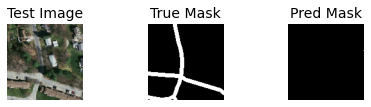

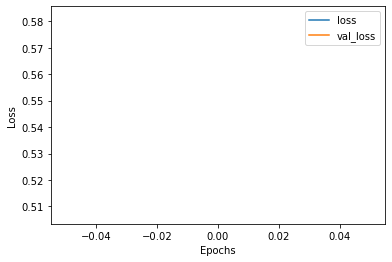

1350/1350 [==============================] - 5s 4ms/sample - loss: 0.5819 - val_loss: 0.5072
Epoch 2/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.4560
Epoch 00002: val_loss improved from 0.50716 to 0.39542, saving model to model.h5
sampling a predictive mask


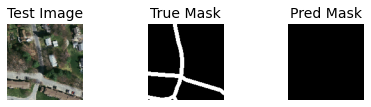

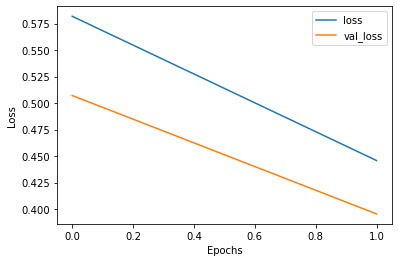

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.4458 - val_loss: 0.3954
Epoch 3/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.3401
Epoch 00003: val_loss improved from 0.39542 to 0.31783, saving model to model.h5
sampling a predictive mask


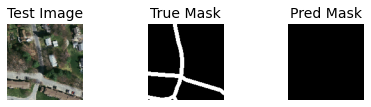

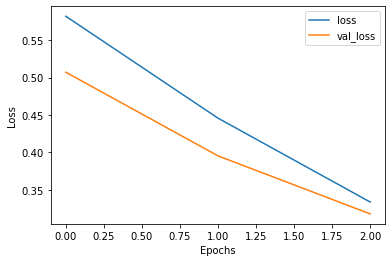

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.3337 - val_loss: 0.3178
Epoch 4/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.3342
Epoch 00004: val_loss improved from 0.31783 to 0.31256, saving model to model.h5
sampling a predictive mask


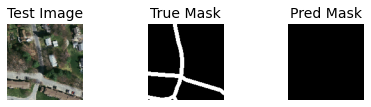

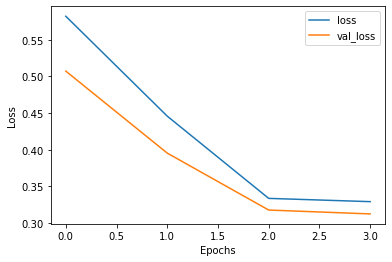

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.3293 - val_loss: 0.3126
Epoch 5/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.3093
Epoch 00005: val_loss did not improve from 0.31256
sampling a predictive mask


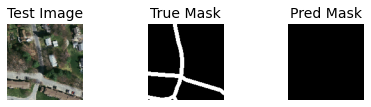

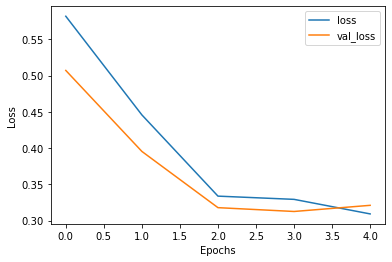

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.3092 - val_loss: 0.3210
Epoch 6/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.3083
Epoch 00006: val_loss did not improve from 0.31256
sampling a predictive mask


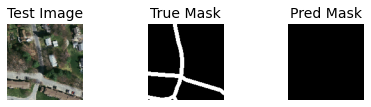

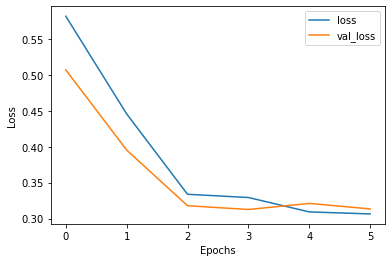

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.3064 - val_loss: 0.3133
Epoch 7/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.3012
Epoch 00007: val_loss improved from 0.31256 to 0.29707, saving model to model.h5
sampling a predictive mask


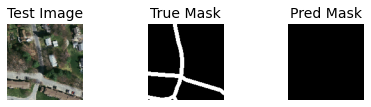

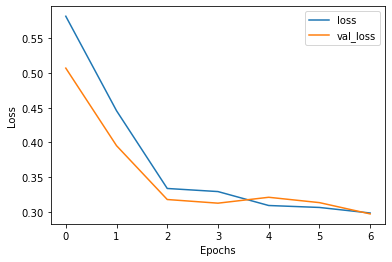

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.2984 - val_loss: 0.2971
Epoch 8/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2905
Epoch 00008: val_loss improved from 0.29707 to 0.28970, saving model to model.h5
sampling a predictive mask


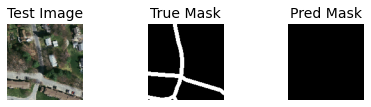

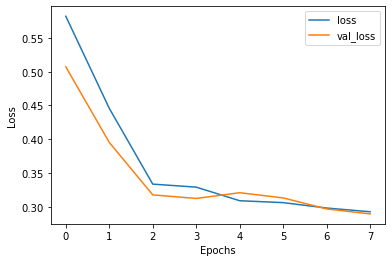

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.2929 - val_loss: 0.2897
Epoch 9/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2815
Epoch 00009: val_loss improved from 0.28970 to 0.28367, saving model to model.h5
sampling a predictive mask


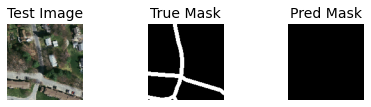

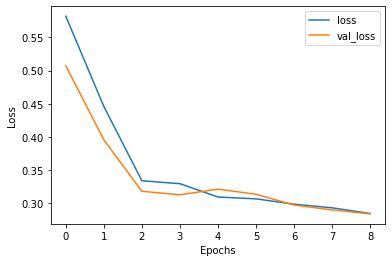

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.2843 - val_loss: 0.2837
Epoch 10/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2698
Epoch 00010: val_loss improved from 0.28367 to 0.26263, saving model to model.h5
sampling a predictive mask


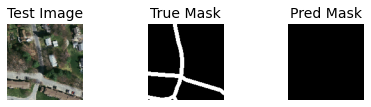

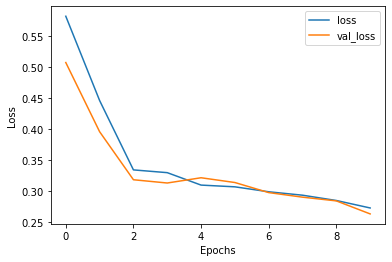

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.2722 - val_loss: 0.2626
Epoch 11/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2608
Epoch 00011: val_loss improved from 0.26263 to 0.25361, saving model to model.h5
sampling a predictive mask


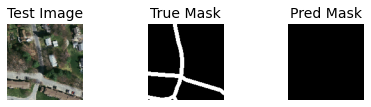

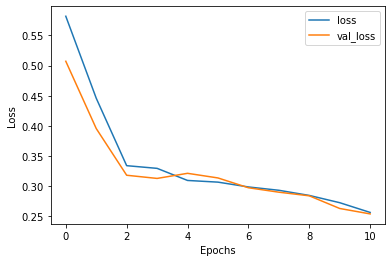

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.2561 - val_loss: 0.2536
Epoch 12/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2371
Epoch 00012: val_loss improved from 0.25361 to 0.24230, saving model to model.h5
sampling a predictive mask


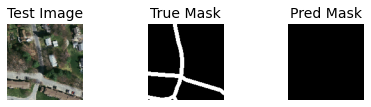

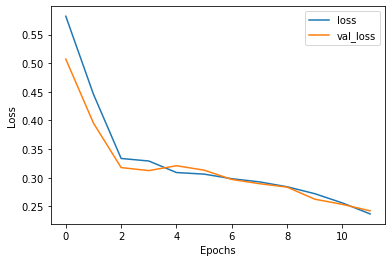

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.2370 - val_loss: 0.2423
Epoch 13/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2214
Epoch 00013: val_loss improved from 0.24230 to 0.22124, saving model to model.h5
sampling a predictive mask


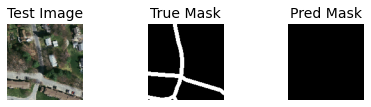

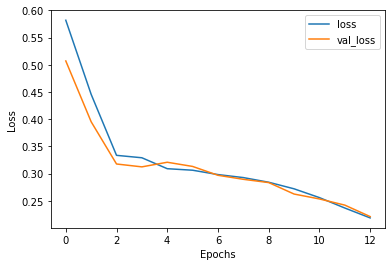

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.2188 - val_loss: 0.2212
Epoch 14/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2051
Epoch 00014: val_loss improved from 0.22124 to 0.20419, saving model to model.h5
sampling a predictive mask


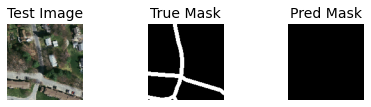

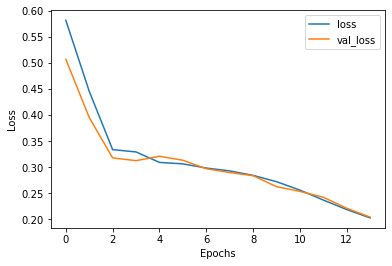

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.2027 - val_loss: 0.2042
Epoch 15/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1958
Epoch 00015: val_loss improved from 0.20419 to 0.18784, saving model to model.h5
sampling a predictive mask


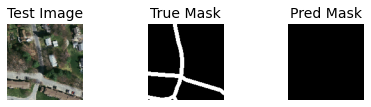

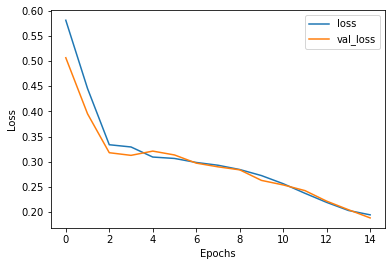

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1940 - val_loss: 0.1878
Epoch 16/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1919
Epoch 00016: val_loss improved from 0.18784 to 0.18153, saving model to model.h5
sampling a predictive mask


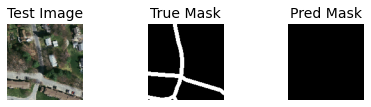

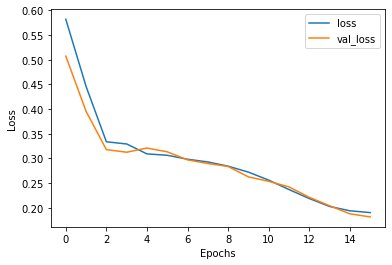

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1903 - val_loss: 0.1815
Epoch 17/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1886
Epoch 00017: val_loss improved from 0.18153 to 0.17951, saving model to model.h5
sampling a predictive mask


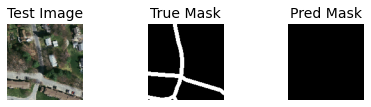

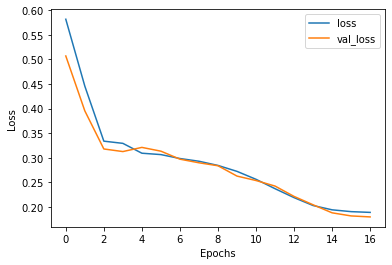

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1887 - val_loss: 0.1795
Epoch 18/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1921
Epoch 00018: val_loss did not improve from 0.17951
sampling a predictive mask


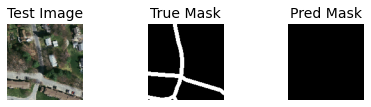

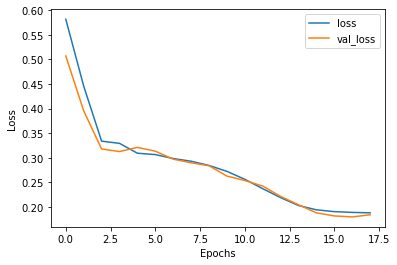

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1878 - val_loss: 0.1838
Epoch 19/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1911
Epoch 00019: val_loss did not improve from 0.17951
sampling a predictive mask


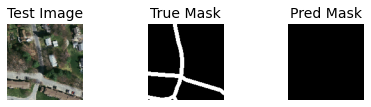

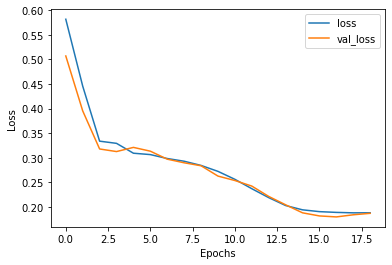

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1879 - val_loss: 0.1868
Epoch 20/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1840
Epoch 00020: val_loss did not improve from 0.17951
sampling a predictive mask


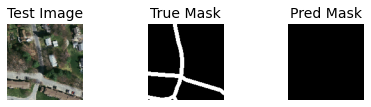

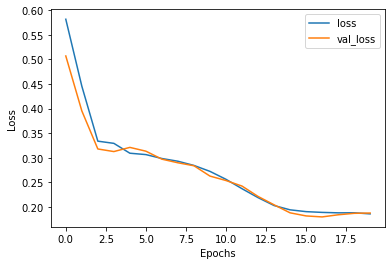

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1857 - val_loss: 0.1874
Epoch 21/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1839
Epoch 00021: val_loss improved from 0.17951 to 0.17868, saving model to model.h5
sampling a predictive mask


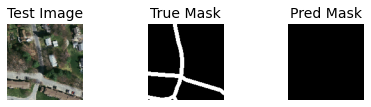

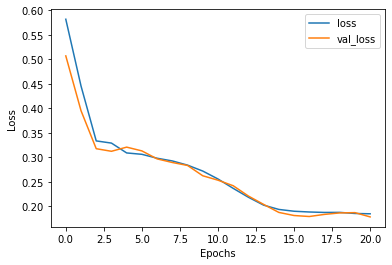

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1851 - val_loss: 0.1787
Epoch 22/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1861
Epoch 00022: val_loss improved from 0.17868 to 0.17331, saving model to model.h5
sampling a predictive mask


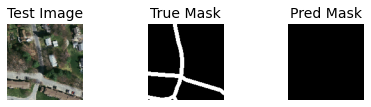

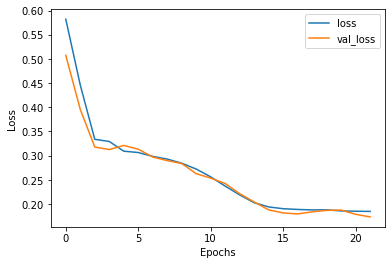

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1847 - val_loss: 0.1733
Epoch 23/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1832
Epoch 00023: val_loss did not improve from 0.17331
sampling a predictive mask


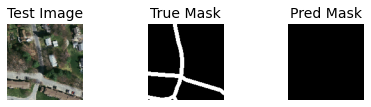

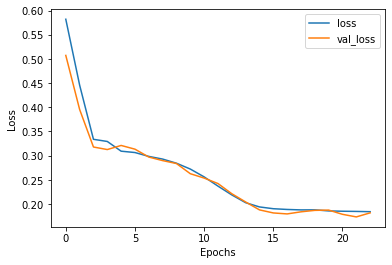

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1841 - val_loss: 0.1817
Epoch 24/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1778
Epoch 00024: val_loss did not improve from 0.17331
sampling a predictive mask


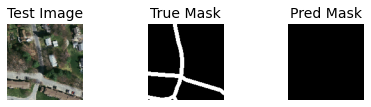

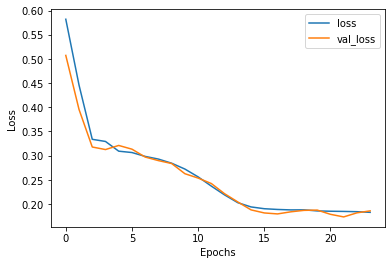

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1828 - val_loss: 0.1858
Epoch 25/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1850
Epoch 00025: val_loss did not improve from 0.17331
sampling a predictive mask


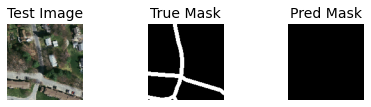

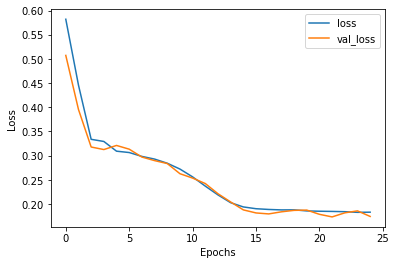

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1831 - val_loss: 0.1743
Epoch 26/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1840
Epoch 00026: val_loss improved from 0.17331 to 0.17214, saving model to model.h5
sampling a predictive mask


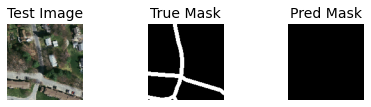

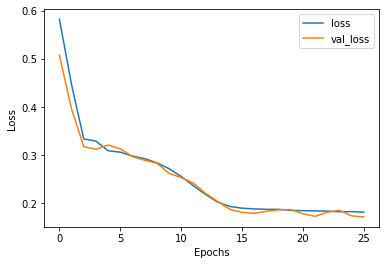

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1819 - val_loss: 0.1721
Epoch 27/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1820
Epoch 00027: val_loss did not improve from 0.17214
sampling a predictive mask


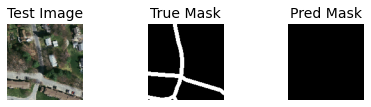

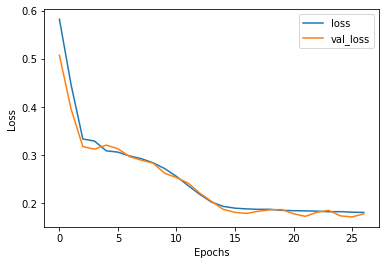

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1814 - val_loss: 0.1786
Epoch 28/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1790
Epoch 00028: val_loss did not improve from 0.17214
sampling a predictive mask


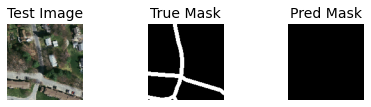

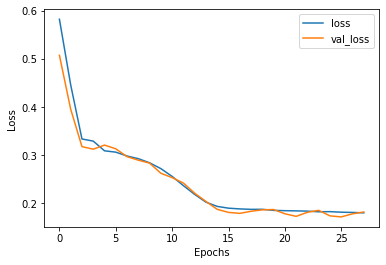

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1806 - val_loss: 0.1823
Epoch 29/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1748
Epoch 00029: val_loss did not improve from 0.17214
sampling a predictive mask


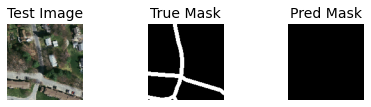

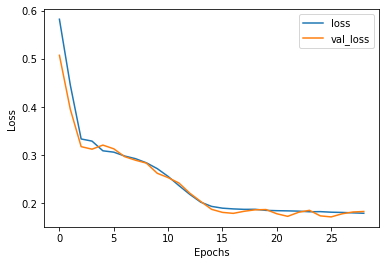

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1797 - val_loss: 0.1834
Epoch 30/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1829
Epoch 00030: val_loss improved from 0.17214 to 0.16685, saving model to model.h5
sampling a predictive mask


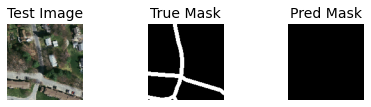

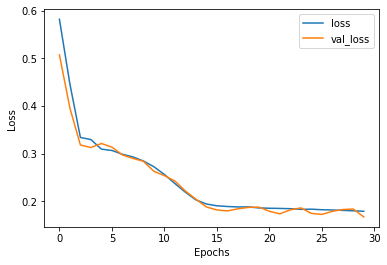

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1787 - val_loss: 0.1669
Epoch 31/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1794
Epoch 00031: val_loss improved from 0.16685 to 0.16574, saving model to model.h5
sampling a predictive mask


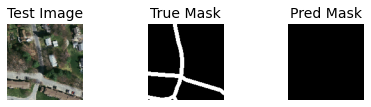

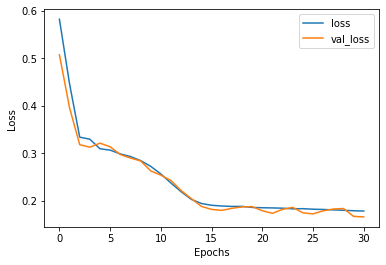

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1781 - val_loss: 0.1657
Epoch 32/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1787
Epoch 00032: val_loss did not improve from 0.16574
sampling a predictive mask


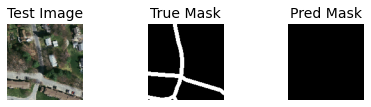

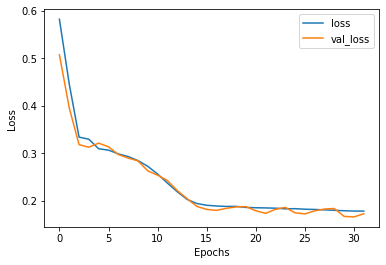

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1779 - val_loss: 0.1724
Epoch 33/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1734
Epoch 00033: val_loss did not improve from 0.16574
sampling a predictive mask


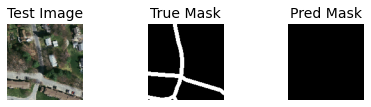

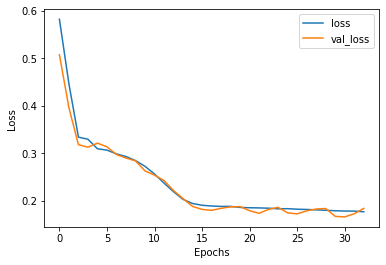

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1766 - val_loss: 0.1837
Epoch 34/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1785
Epoch 00034: val_loss did not improve from 0.16574
sampling a predictive mask


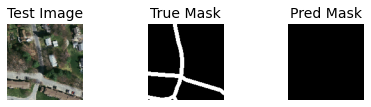

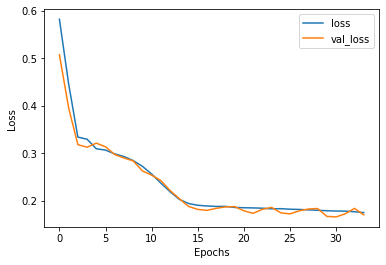

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1748 - val_loss: 0.1701
Epoch 35/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1715
Epoch 00035: val_loss improved from 0.16574 to 0.16258, saving model to model.h5
sampling a predictive mask


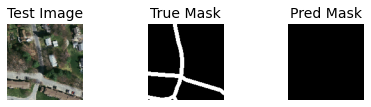

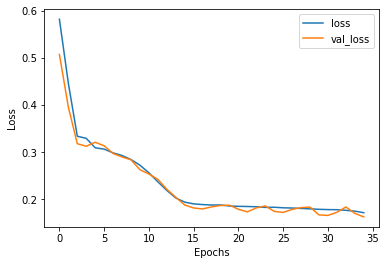

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1715 - val_loss: 0.1626
Epoch 36/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1712
Epoch 00036: val_loss improved from 0.16258 to 0.16037, saving model to model.h5
sampling a predictive mask


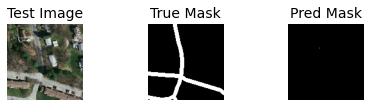

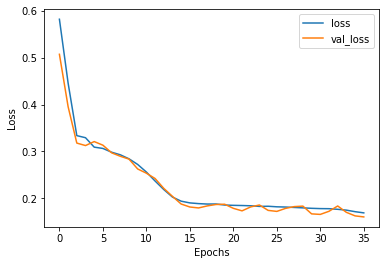

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1690 - val_loss: 0.1604
Epoch 37/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1724
Epoch 00037: val_loss did not improve from 0.16037
sampling a predictive mask


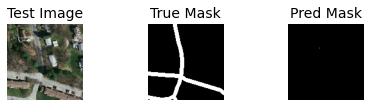

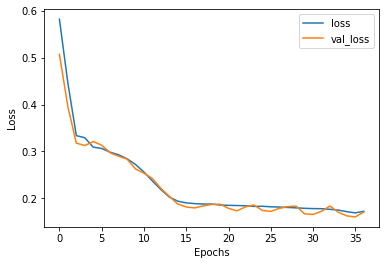

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1724 - val_loss: 0.1709
Epoch 38/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1711
Epoch 00038: val_loss did not improve from 0.16037
sampling a predictive mask


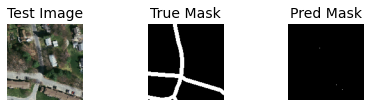

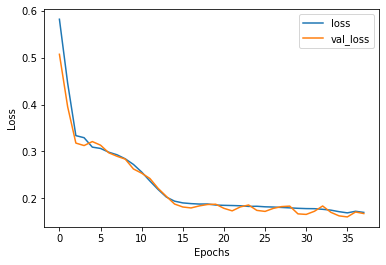

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1700 - val_loss: 0.1675
Epoch 39/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1671
Epoch 00039: val_loss did not improve from 0.16037
sampling a predictive mask


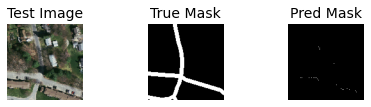

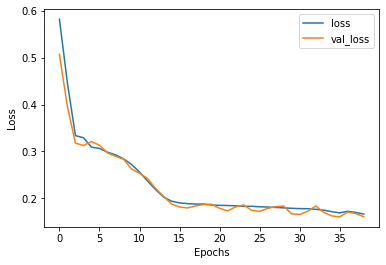

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1664 - val_loss: 0.1609
Epoch 40/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1659
Epoch 00040: val_loss improved from 0.16037 to 0.15642, saving model to model.h5
sampling a predictive mask


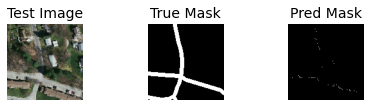

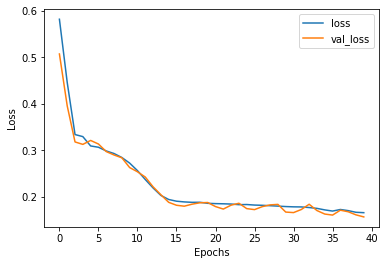

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1655 - val_loss: 0.1564
Epoch 41/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1601
Epoch 00041: val_loss improved from 0.15642 to 0.15267, saving model to model.h5
sampling a predictive mask


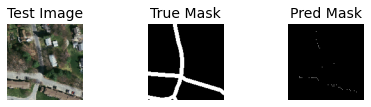

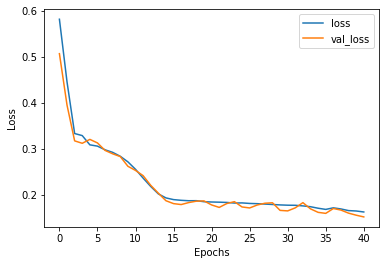

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1634 - val_loss: 0.1527
Epoch 42/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1646
Epoch 00042: val_loss did not improve from 0.15267
sampling a predictive mask


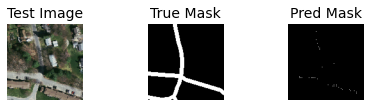

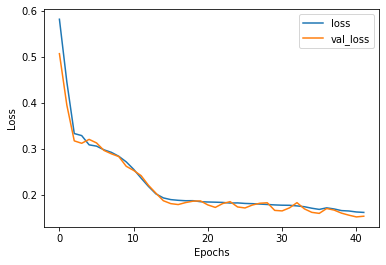

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1624 - val_loss: 0.1542
Epoch 43/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1603
Epoch 00043: val_loss improved from 0.15267 to 0.14963, saving model to model.h5
sampling a predictive mask


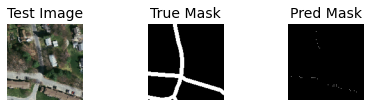

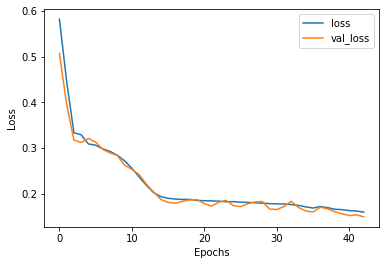

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1602 - val_loss: 0.1496
Epoch 44/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1584
Epoch 00044: val_loss did not improve from 0.14963
sampling a predictive mask


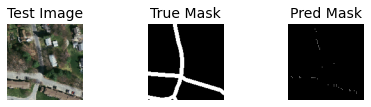

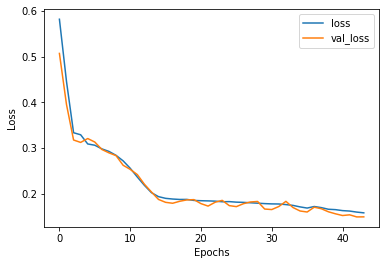

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1585 - val_loss: 0.1498
Epoch 45/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1536
Epoch 00045: val_loss did not improve from 0.14963
sampling a predictive mask


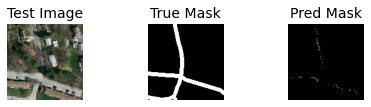

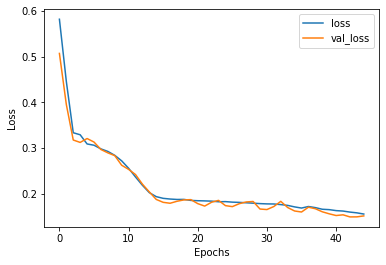

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1559 - val_loss: 0.1518
Epoch 46/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1548
Epoch 00046: val_loss improved from 0.14963 to 0.14493, saving model to model.h5
sampling a predictive mask


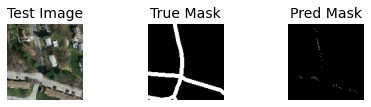

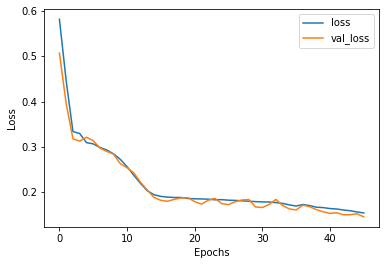

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1537 - val_loss: 0.1449
Epoch 47/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1532
Epoch 00047: val_loss did not improve from 0.14493
sampling a predictive mask


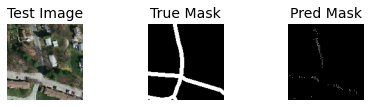

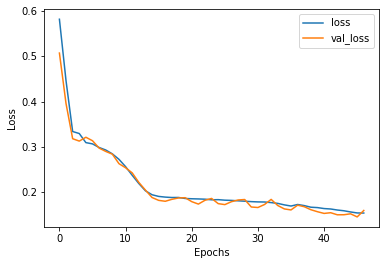

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1535 - val_loss: 0.1592
Epoch 48/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1521
Epoch 00048: val_loss did not improve from 0.14493
sampling a predictive mask


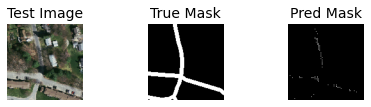

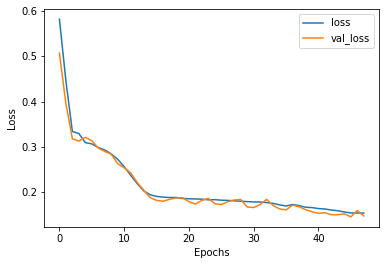

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1535 - val_loss: 0.1470
Epoch 49/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1476
Epoch 00049: val_loss improved from 0.14493 to 0.14293, saving model to model.h5
sampling a predictive mask


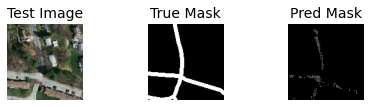

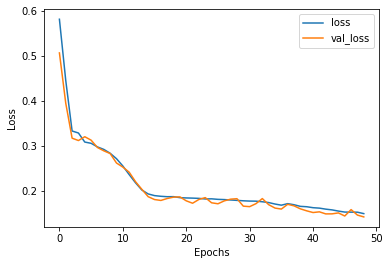

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1502 - val_loss: 0.1429
Epoch 50/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1495
Epoch 00050: val_loss improved from 0.14293 to 0.14224, saving model to model.h5
sampling a predictive mask


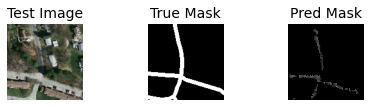

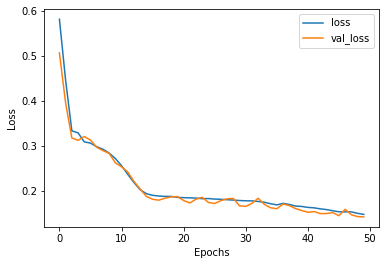

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1478 - val_loss: 0.1422
Epoch 51/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1448
Epoch 00051: val_loss did not improve from 0.14224
sampling a predictive mask


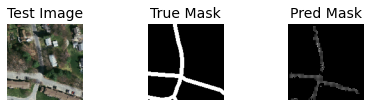

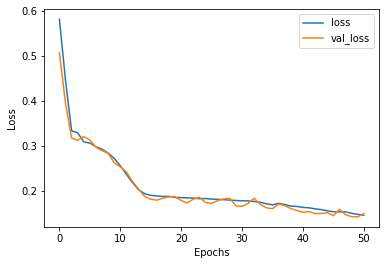

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1460 - val_loss: 0.1496
Epoch 52/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1456
Epoch 00052: val_loss improved from 0.14224 to 0.13561, saving model to model.h5
sampling a predictive mask


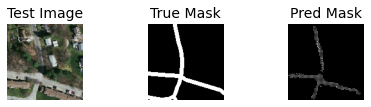

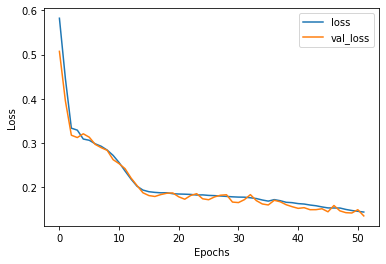

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1443 - val_loss: 0.1356
Epoch 53/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1412
Epoch 00053: val_loss did not improve from 0.13561
sampling a predictive mask


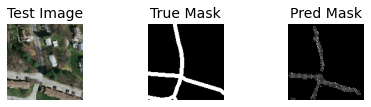

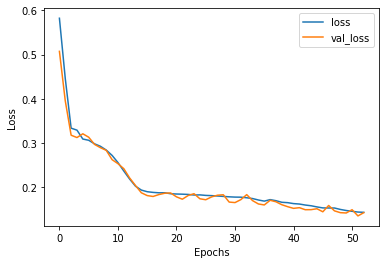

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1437 - val_loss: 0.1430
Epoch 54/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1424
Epoch 00054: val_loss did not improve from 0.13561
sampling a predictive mask


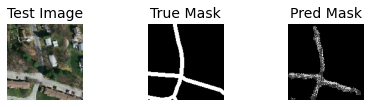

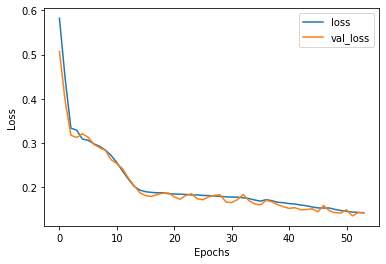

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1427 - val_loss: 0.1424
Epoch 55/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1410
Epoch 00055: val_loss did not improve from 0.13561
sampling a predictive mask


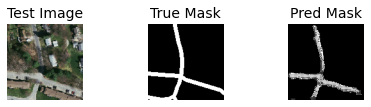

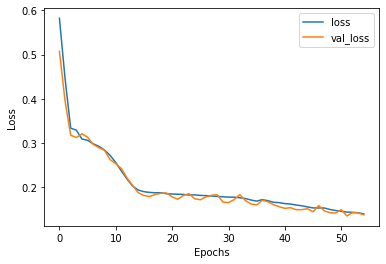

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1403 - val_loss: 0.1381
Epoch 56/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1389
Epoch 00056: val_loss improved from 0.13561 to 0.12979, saving model to model.h5
sampling a predictive mask


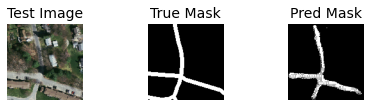

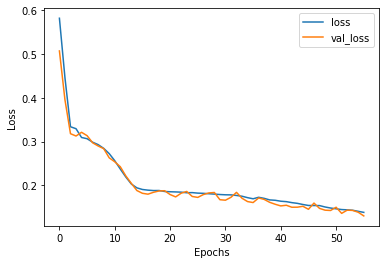

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1379 - val_loss: 0.1298
Epoch 57/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1357
Epoch 00057: val_loss did not improve from 0.12979
sampling a predictive mask


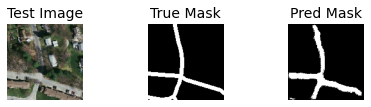

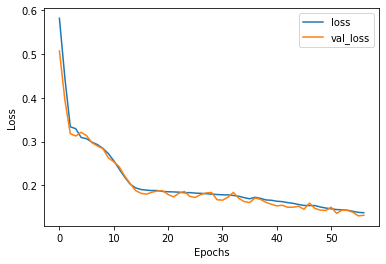

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1371 - val_loss: 0.1313
Epoch 58/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1353
Epoch 00058: val_loss improved from 0.12979 to 0.12757, saving model to model.h5
sampling a predictive mask


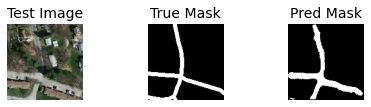

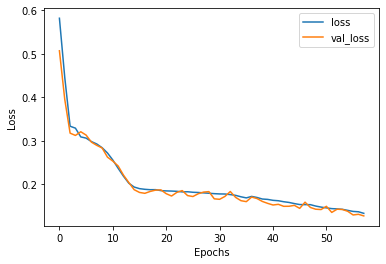

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1335 - val_loss: 0.1276
Epoch 59/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1320
Epoch 00059: val_loss did not improve from 0.12757
sampling a predictive mask


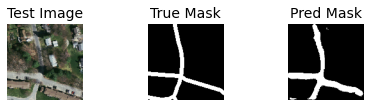

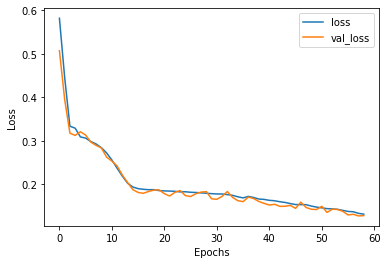

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1316 - val_loss: 0.1283
Epoch 60/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1321
Epoch 00060: val_loss improved from 0.12757 to 0.12478, saving model to model.h5
sampling a predictive mask


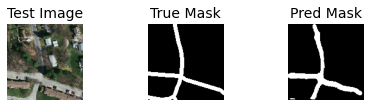

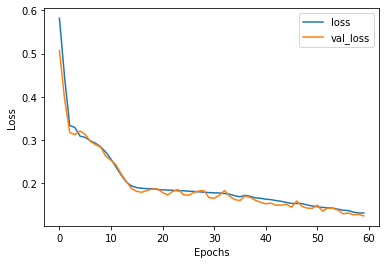

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1314 - val_loss: 0.1248
Epoch 61/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1293
Epoch 00061: val_loss improved from 0.12478 to 0.12115, saving model to model.h5
sampling a predictive mask


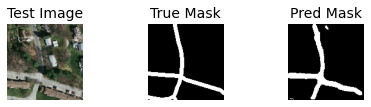

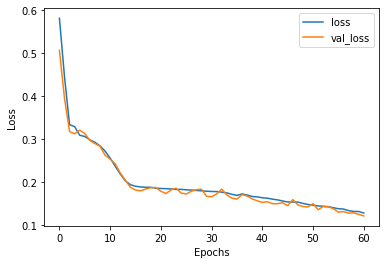

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1278 - val_loss: 0.1211
Epoch 62/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1246
Epoch 00062: val_loss did not improve from 0.12115
sampling a predictive mask


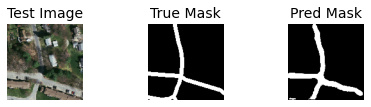

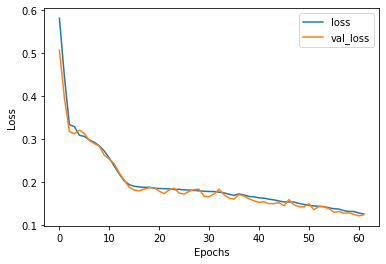

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1257 - val_loss: 0.1237
Epoch 63/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1246
Epoch 00063: val_loss improved from 0.12115 to 0.11845, saving model to model.h5
sampling a predictive mask


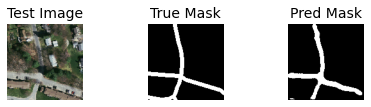

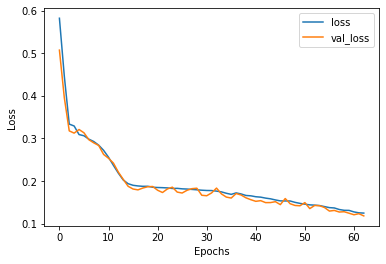

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1251 - val_loss: 0.1184
Epoch 64/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1199
Epoch 00064: val_loss did not improve from 0.11845
sampling a predictive mask


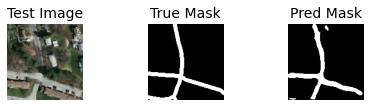

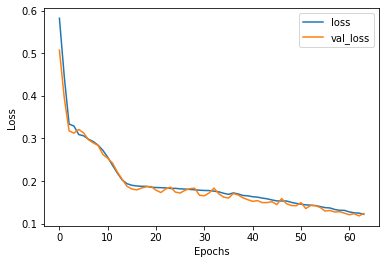

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1222 - val_loss: 0.1240
Epoch 65/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1188
Epoch 00065: val_loss did not improve from 0.11845
sampling a predictive mask


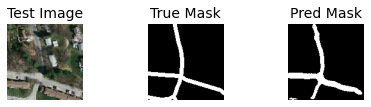

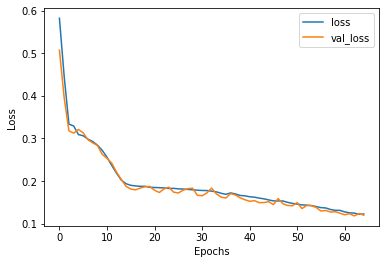

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1230 - val_loss: 0.1202
Epoch 66/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1185
Epoch 00066: val_loss improved from 0.11845 to 0.11683, saving model to model.h5
sampling a predictive mask


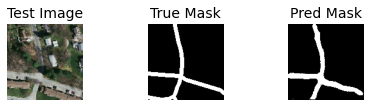

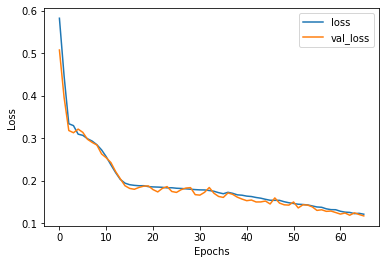

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1208 - val_loss: 0.1168
Epoch 67/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1181
Epoch 00067: val_loss did not improve from 0.11683
sampling a predictive mask


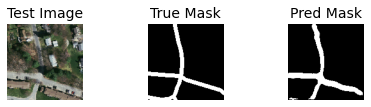

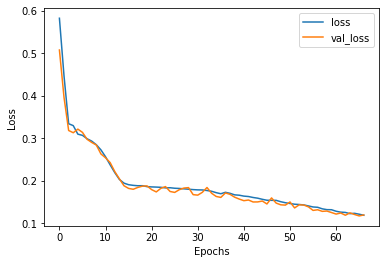

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1184 - val_loss: 0.1190
Epoch 68/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1168
Epoch 00068: val_loss did not improve from 0.11683
sampling a predictive mask


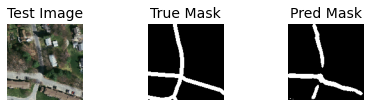

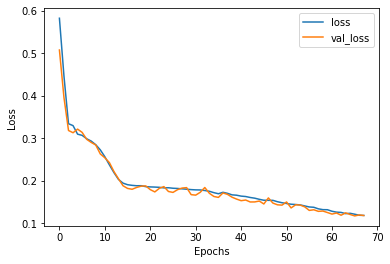

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1179 - val_loss: 0.1178
Epoch 69/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1184
Epoch 00069: val_loss improved from 0.11683 to 0.11635, saving model to model.h5
sampling a predictive mask


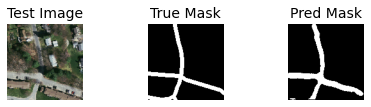

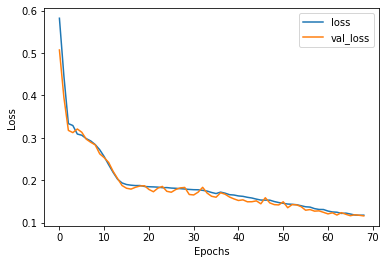

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1181 - val_loss: 0.1163
Epoch 70/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1157
Epoch 00070: val_loss improved from 0.11635 to 0.11545, saving model to model.h5
sampling a predictive mask


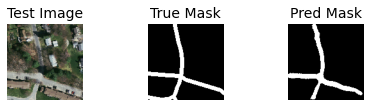

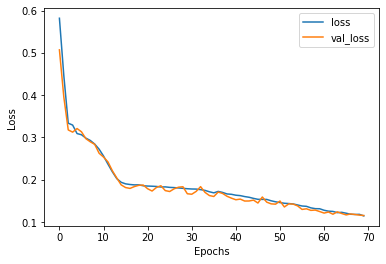

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1144 - val_loss: 0.1155
Epoch 71/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1130
Epoch 00071: val_loss improved from 0.11545 to 0.11379, saving model to model.h5
sampling a predictive mask


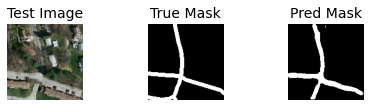

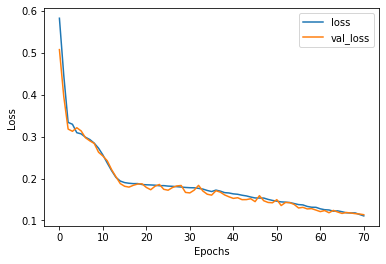

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1109 - val_loss: 0.1138
Epoch 72/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1074
Epoch 00072: val_loss did not improve from 0.11379
sampling a predictive mask


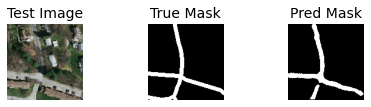

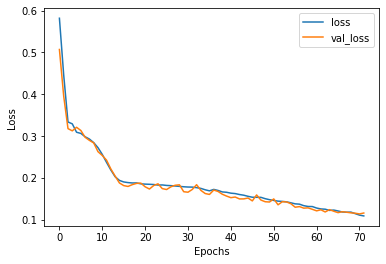

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1090 - val_loss: 0.1159
Epoch 73/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1072
Epoch 00073: val_loss did not improve from 0.11379
sampling a predictive mask


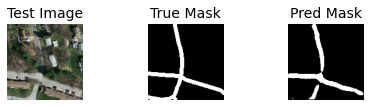

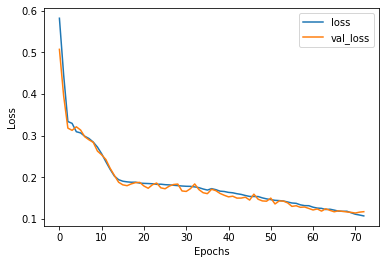

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1069 - val_loss: 0.1170
Epoch 74/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1052
Epoch 00074: val_loss did not improve from 0.11379
sampling a predictive mask


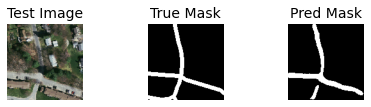

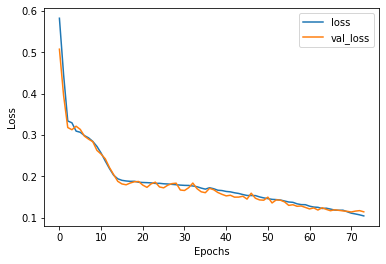

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1043 - val_loss: 0.1142
Epoch 75/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1039
Epoch 00075: val_loss improved from 0.11379 to 0.11259, saving model to model.h5
sampling a predictive mask


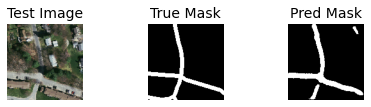

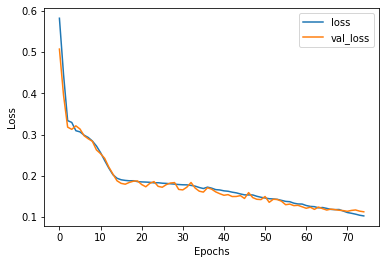

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1026 - val_loss: 0.1126
Epoch 76/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1016
Epoch 00076: val_loss did not improve from 0.11259
sampling a predictive mask


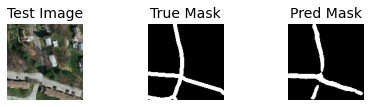

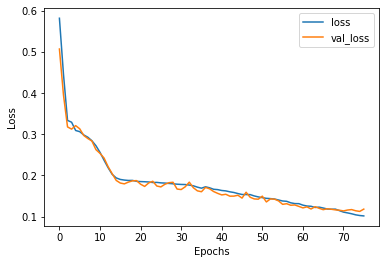

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1016 - val_loss: 0.1182
Epoch 77/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0991
Epoch 00077: val_loss did not improve from 0.11259
sampling a predictive mask


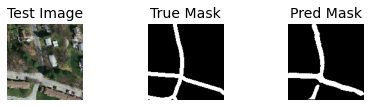

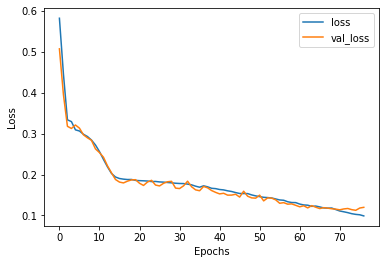

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0989 - val_loss: 0.1198
Epoch 78/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0969
Epoch 00078: val_loss did not improve from 0.11259
sampling a predictive mask


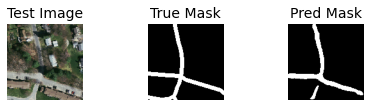

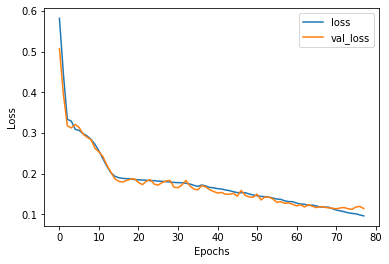

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0964 - val_loss: 0.1145
Epoch 79/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0952
Epoch 00079: val_loss did not improve from 0.11259
sampling a predictive mask


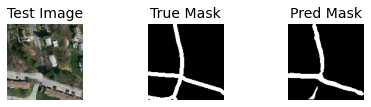

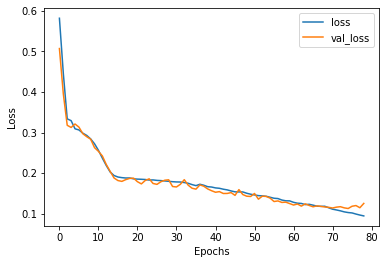

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0943 - val_loss: 0.1251
Epoch 80/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0913
Epoch 00080: val_loss did not improve from 0.11259
sampling a predictive mask


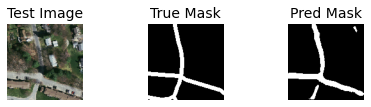

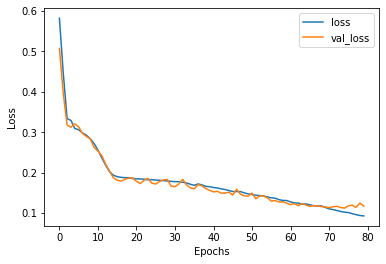

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0933 - val_loss: 0.1176
Epoch 81/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0922
Epoch 00081: val_loss did not improve from 0.11259
sampling a predictive mask


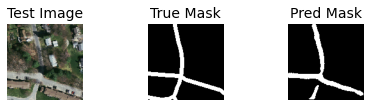

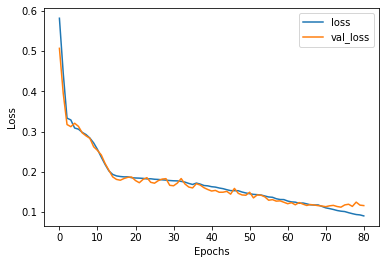

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0908 - val_loss: 0.1165
Epoch 82/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0907
Epoch 00082: val_loss did not improve from 0.11259
sampling a predictive mask


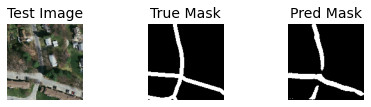

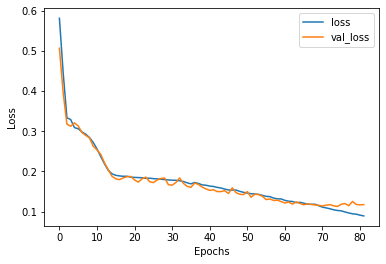

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0890 - val_loss: 0.1172
Epoch 83/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0855
Epoch 00083: val_loss did not improve from 0.11259
sampling a predictive mask


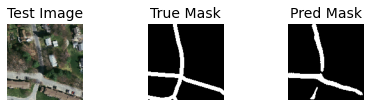

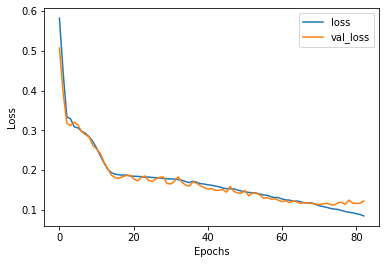

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0854 - val_loss: 0.1229
Epoch 84/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0816
Epoch 00084: val_loss did not improve from 0.11259
sampling a predictive mask


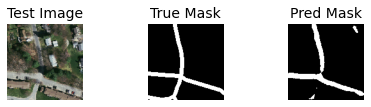

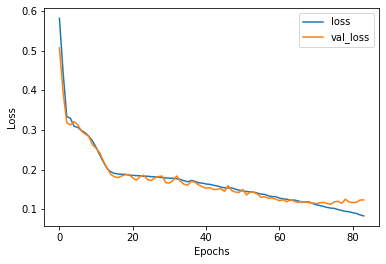

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0828 - val_loss: 0.1232
Epoch 85/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0829
Epoch 00085: val_loss did not improve from 0.11259
sampling a predictive mask


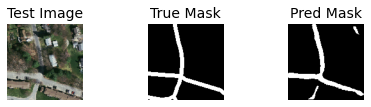

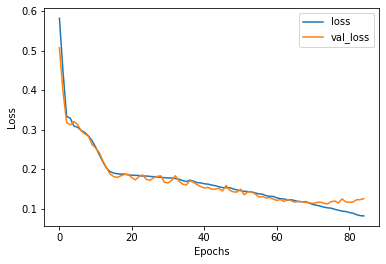

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0821 - val_loss: 0.1261
Epoch 86/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0835
Epoch 00086: val_loss did not improve from 0.11259
sampling a predictive mask


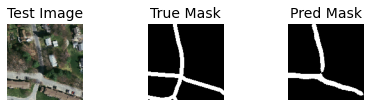

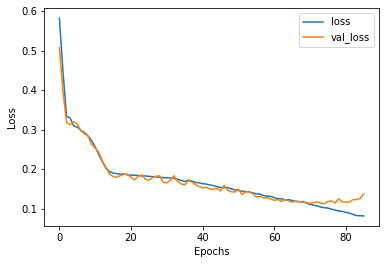

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0818 - val_loss: 0.1382
Epoch 87/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0800
Epoch 00087: val_loss did not improve from 0.11259
sampling a predictive mask


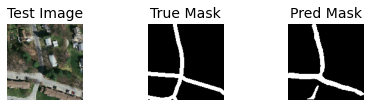

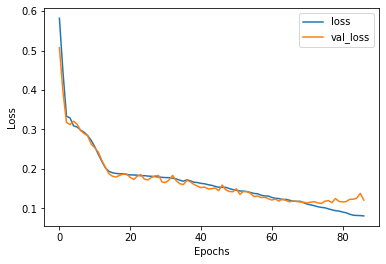

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0810 - val_loss: 0.1211
Epoch 88/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0780
Epoch 00088: val_loss did not improve from 0.11259
sampling a predictive mask


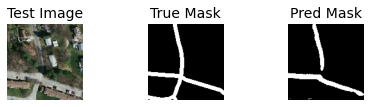

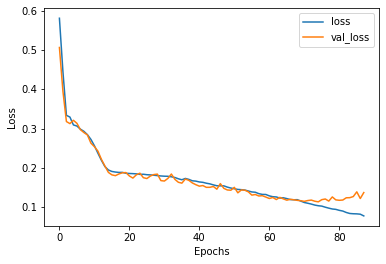

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0766 - val_loss: 0.1363
Epoch 89/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0752
Epoch 00089: val_loss did not improve from 0.11259
sampling a predictive mask


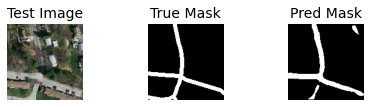

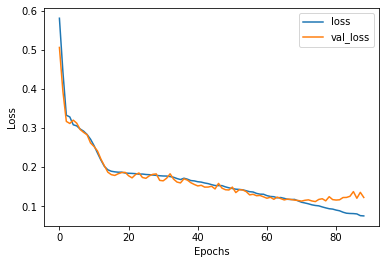

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0759 - val_loss: 0.1231
Epoch 90/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0781
Epoch 00090: val_loss did not improve from 0.11259
sampling a predictive mask


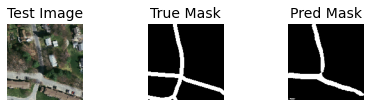

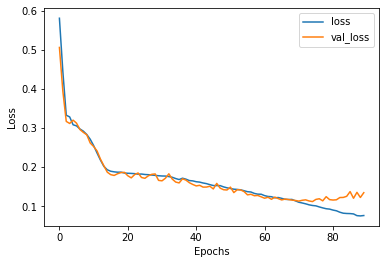

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0769 - val_loss: 0.1354
Epoch 91/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0737
Epoch 00091: val_loss did not improve from 0.11259
sampling a predictive mask


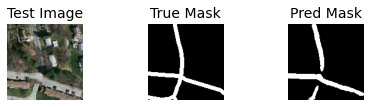

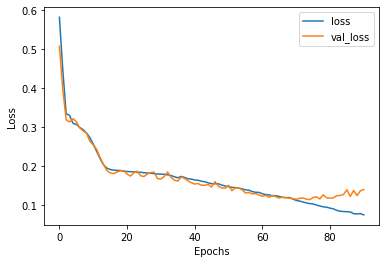

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0734 - val_loss: 0.1388
Epoch 92/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0719
Epoch 00092: val_loss did not improve from 0.11259
sampling a predictive mask


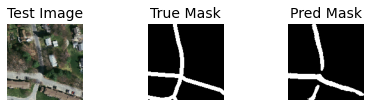

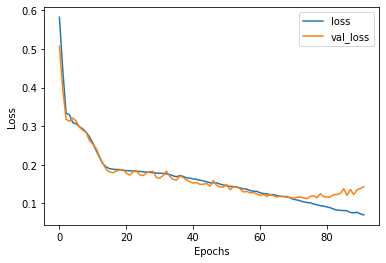

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0704 - val_loss: 0.1435
Epoch 93/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0672
Epoch 00093: val_loss did not improve from 0.11259
sampling a predictive mask


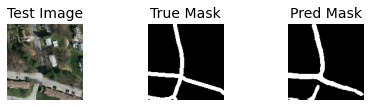

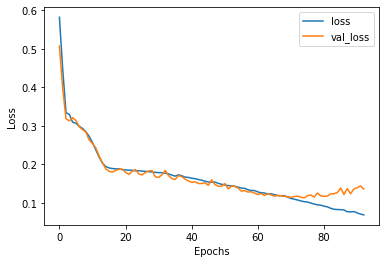

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0681 - val_loss: 0.1355
Epoch 94/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0669
Epoch 00094: val_loss did not improve from 0.11259
sampling a predictive mask


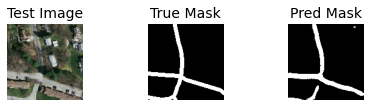

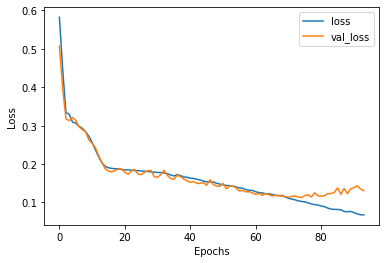

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0677 - val_loss: 0.1306
Epoch 95/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0669
Epoch 00095: val_loss did not improve from 0.11259
sampling a predictive mask


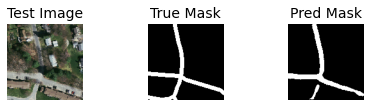

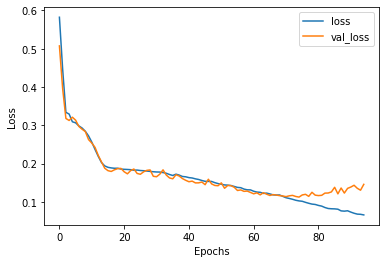

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0661 - val_loss: 0.1458
Epoch 96/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0639
Epoch 00096: val_loss did not improve from 0.11259
sampling a predictive mask


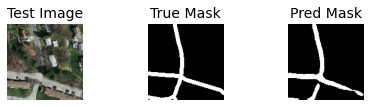

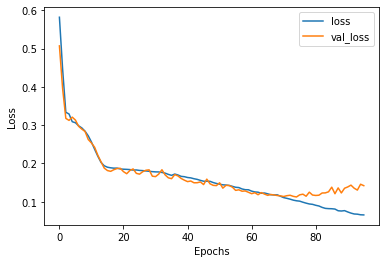

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0657 - val_loss: 0.1421
Epoch 97/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0630
Epoch 00097: val_loss did not improve from 0.11259
sampling a predictive mask


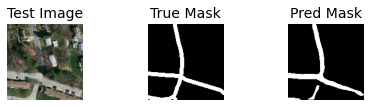

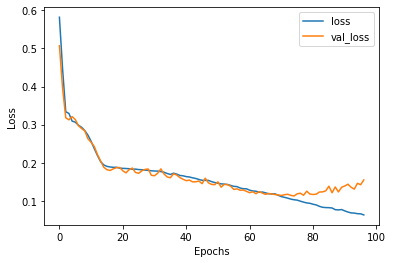

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0628 - val_loss: 0.1547
Epoch 98/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0622
Epoch 00098: val_loss did not improve from 0.11259
sampling a predictive mask


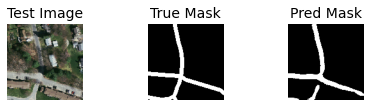

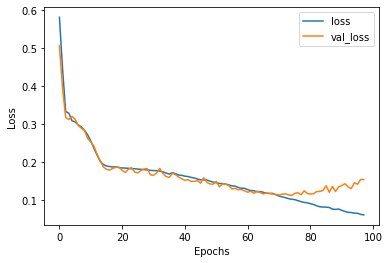

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0614 - val_loss: 0.1545
Epoch 99/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0601
Epoch 00099: val_loss did not improve from 0.11259
sampling a predictive mask


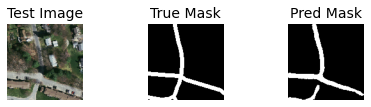

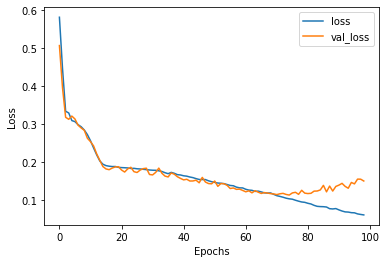

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0601 - val_loss: 0.1496
Epoch 100/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0587
Epoch 00100: val_loss did not improve from 0.11259
sampling a predictive mask


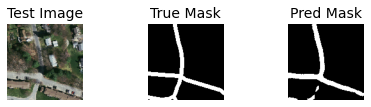

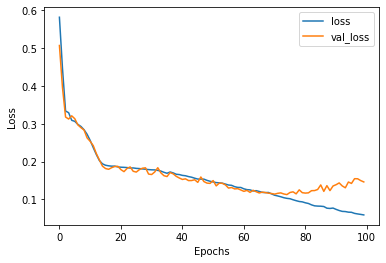

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0588 - val_loss: 0.1461
Epoch 00100: early stopping


In [69]:
filepath = "model.h5"

earlystopper = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')



imagesampler10 = SamplePredictionsCallback(image_index = 10, prediction_thresh = 0.1)
#imagesampler20 = SamplePredictionsCallback(image_index = 3, prediction_thresh = 0.2)
#imagesampler30 = SamplePredictionsCallback(image_index = 3, prediction_thresh = 0.3)
#imagesampler40 = SamplePredictionsCallback(image_index = 3, prediction_thresh = 0.4)
imagesampler50 = SamplePredictionsCallback(image_index = 10, prediction_thresh = 0.5)
#imagesampler60 = SamplePredictionsCallback(image_index = 3, prediction_thresh = 0.6)
imagesampler70 = SamplePredictionsCallback(image_index = 10, prediction_thresh = 0.7)
imagesampler80 = SamplePredictionsCallback(image_index = 10, prediction_thresh = 0.8)
imagesampler90 = SamplePredictionsCallback(image_index = 10, prediction_thresh = 0.9)
#imagesampler100 = SamplePredictionsCallback(image_index = 3, prediction_thresh = 1.0)

callbacks_list = [earlystopper, checkpoint, imagesampler50]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=275, epochs=100, 
                    callbacks=callbacks_list)

In [70]:
model.load_weights('model.h5')

test_preds = model.predict(X_test)

In [71]:
def plot_results(img_idx2, prediction_threshold = 0.5):
    
    preds_test_thresh = (test_preds >= prediction_threshold).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.axis('Off')
    
    # image
    plt.subplot(3,3,1)
    test_image = X_test[img_idx2]
    plt.imshow(test_image)
    plt.title('Test Image {}'.format(img_idx2), fontsize=14)
    plt.axis('off')
    
    # true mask
    plt.subplot(3,3,2)
    mask_id = df_test.loc[img_idx2,'mask_id']
    path_mask = 'Roads DataSet/road_segmentation_ideal/training/output/' + mask_id
    mask = imread(path_mask)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    plt.imshow(mask, cmap='gray')
    plt.title('True Mask {}'.format(img_idx2), fontsize=14)
    plt.axis('off')

        
    # predicted mask
    plt.subplot(3,3,3)
    test_mask = preds_test_thresh[img_idx2, :, :, 0]
    plt.imshow(test_mask, cmap='gray')
    plt.title('Pred Mask {}'.format(img_idx2), fontsize=14)
    plt.axis('off')
    
    
    
    
    plt.tight_layout()
    plt.show()
    
    

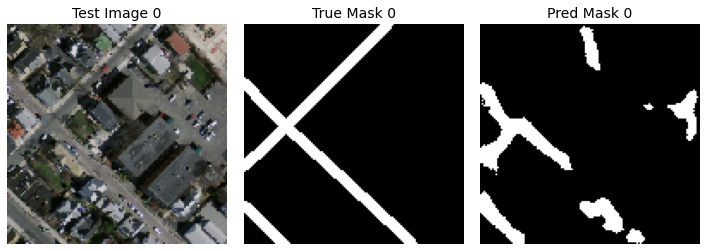

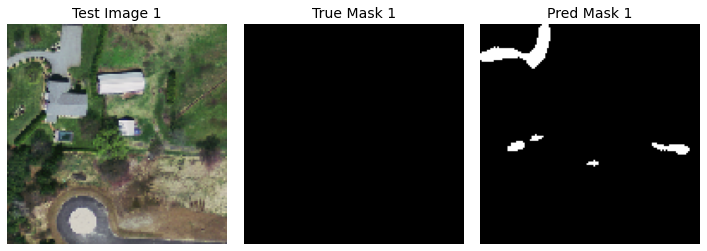

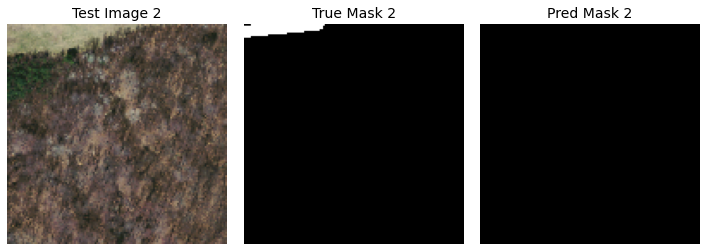

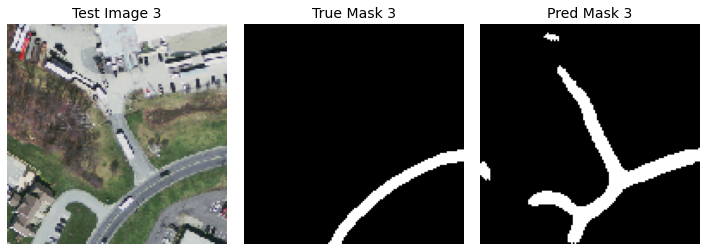

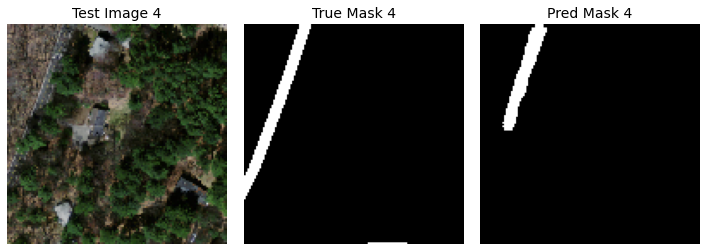

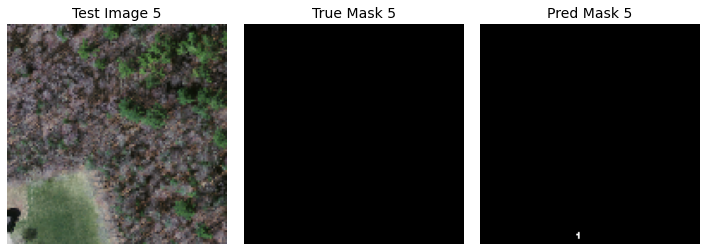

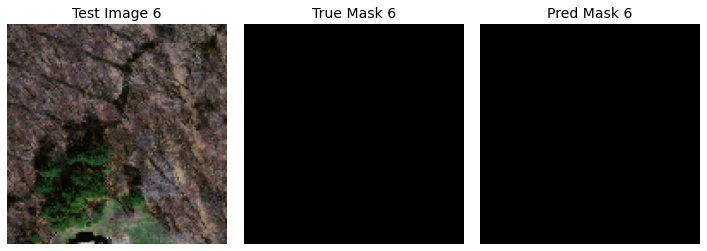

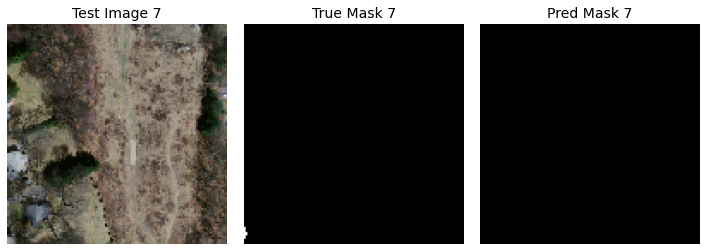

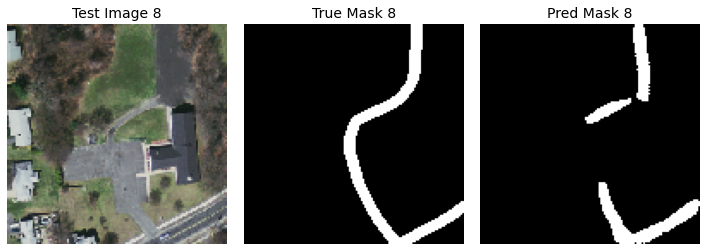

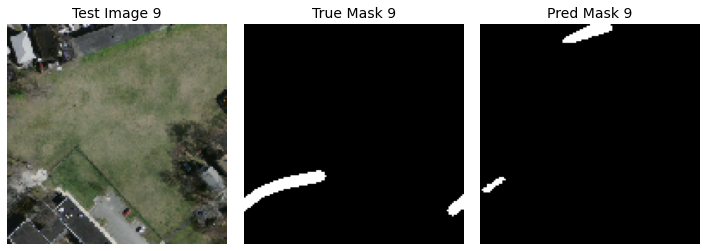

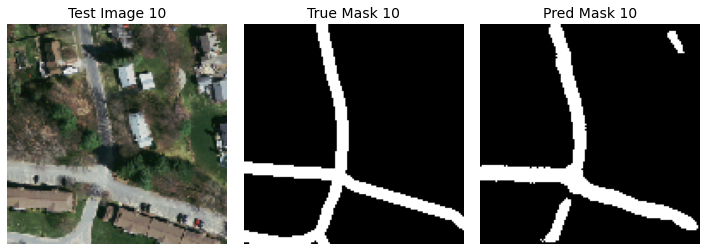

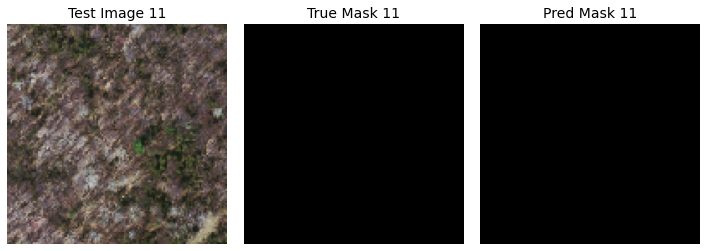

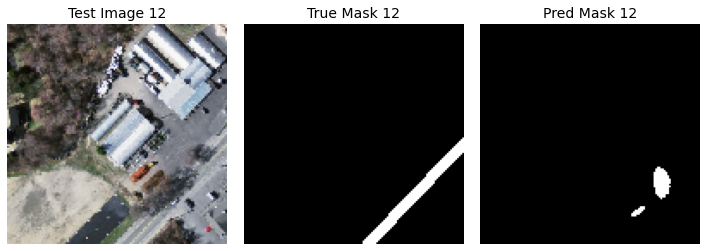

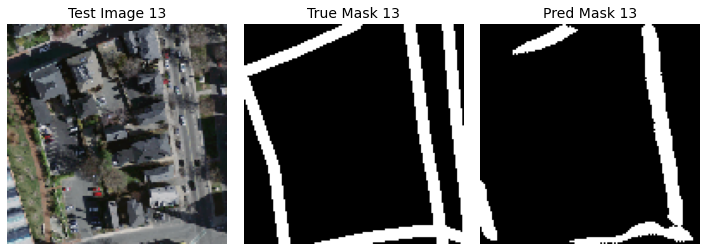

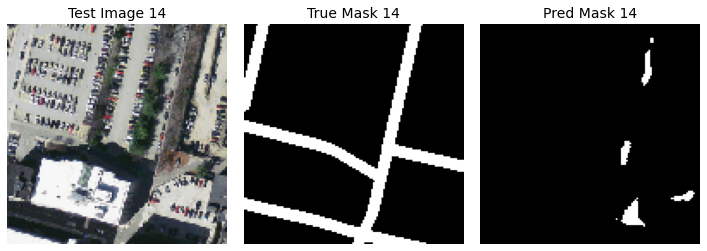

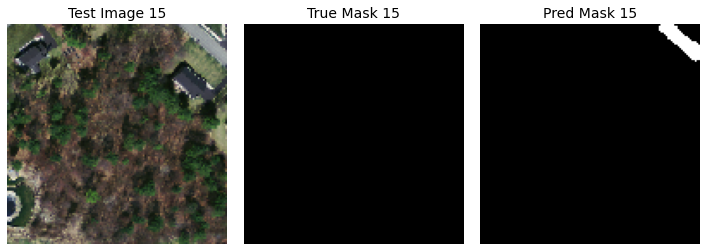

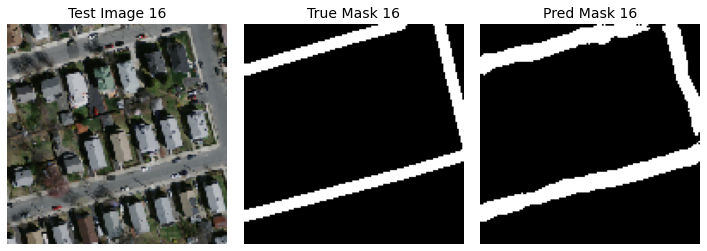

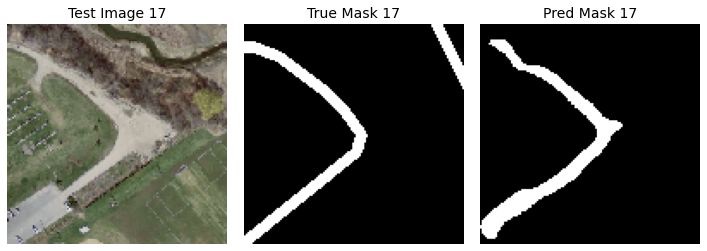

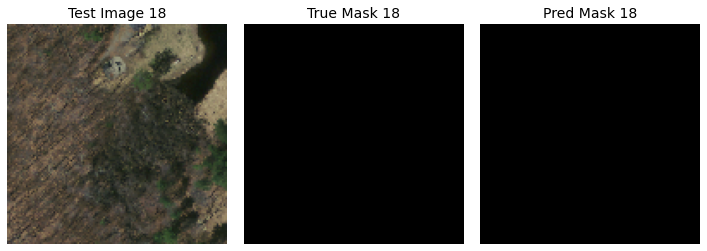

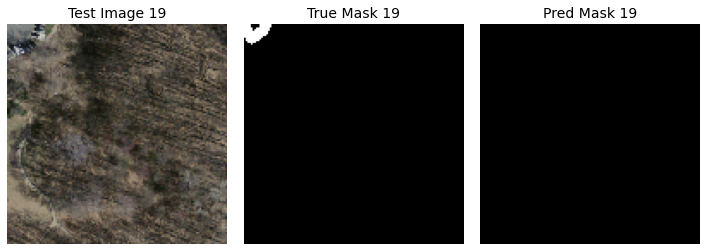

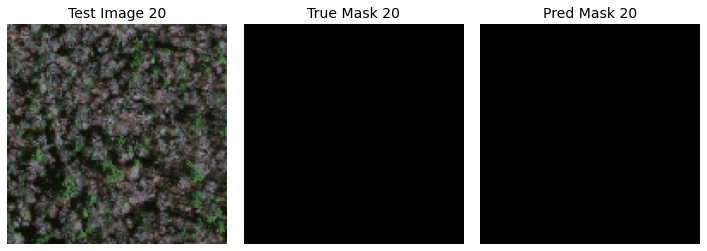

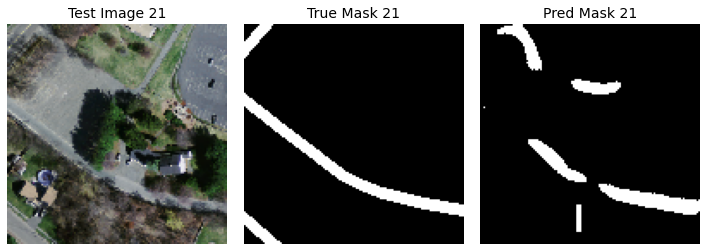

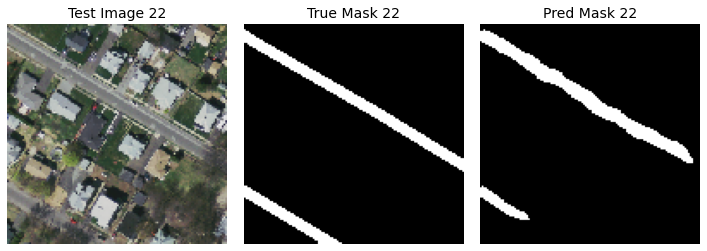

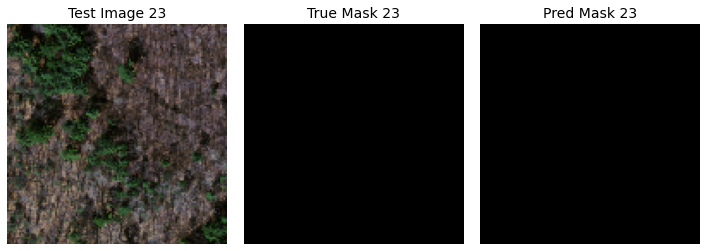

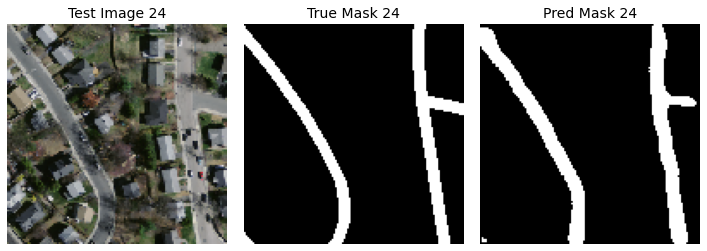

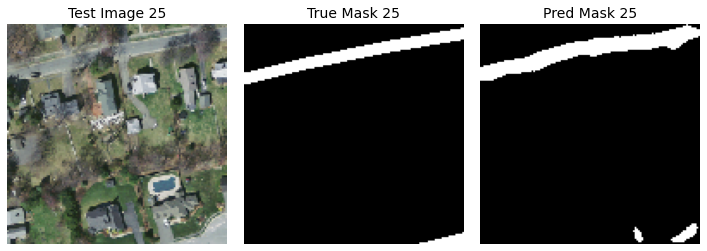

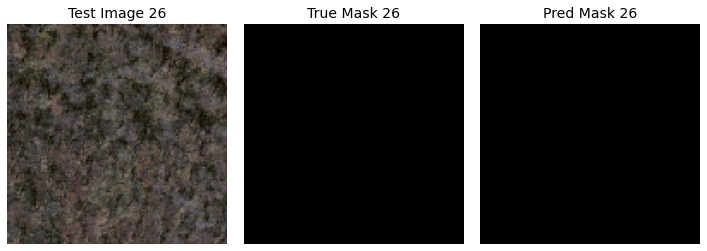

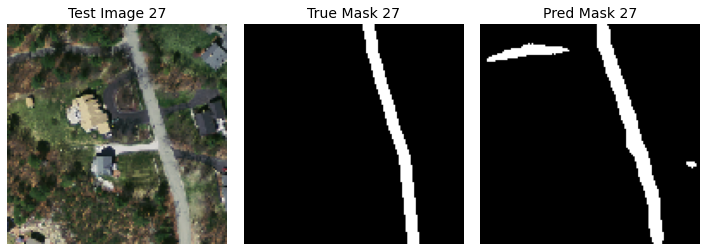

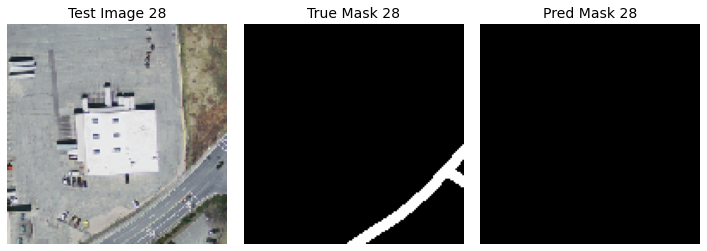

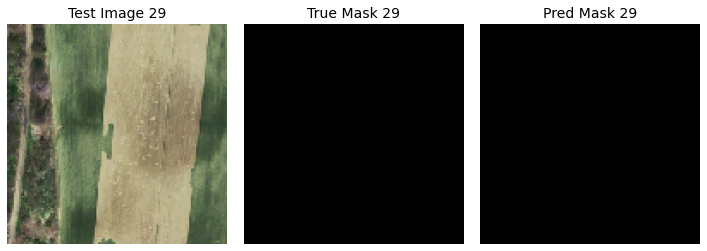

In [72]:
for i in range(len(X_test)):
    plot_results(i, prediction_threshold = 0.5)